##Configuración y rutas

In [11]:

import pandas as pd
import numpy as np
from pathlib import Path

# Ruta base (ajústala a tu carpeta Data)
base_path = Path(r"C:\Users\Jander\Documents\Proyectos-de-Ingenieria\Proyecto_Regresion\Data")

# Archivos
P2022 = base_path / "CO_Nebraska_2022.csv"
P2023 = base_path / "CO_Nebraska_2023.csv"
#P2024 = base_path / "CO_Nebraska_2024.csv"   # opcional
P2025 = base_path / "CO_Nebraska_2025.csv"   # necesario para evaluar

for p in [P2022, P2023, P2024, P2025]:
    print(p.name, "→", "OK" if p.exists() else "NO encontrado")


CO_Nebraska_2022.csv → OK
CO_Nebraska_2023.csv → OK
CO_Nebraska_2024.csv → NO encontrado
CO_Nebraska_2025.csv → OK


##Lectura de datos y concatenación

In [12]:
def load_co_csv(path: Path, year: int) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    date_col = [c for c in df.columns if "date" in c][0]
    target_col = [c for c in df.columns if "co" in c][0]  # target fijo = CO
    df = df.rename(columns={date_col: "date", target_col: "target_co"})
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["year"] = year
    return df[["date", "target_co", "year"]].dropna()

df22 = load_co_csv(P2022, 2022)
df23 = load_co_csv(P2023, 2023)
frames = [df22, df23]

if P2024.exists():
    df24 = load_co_csv(P2024, 2024)
    frames.append(df24)

df_all = pd.concat(frames).sort_values("date").reset_index(drop=True)

print("Shape total:", df_all.shape)
df_all.head()


Shape total: (1398, 3)


,date,target_co,year
0,2022-01-01,0.1,2022
1,2022-01-01,0.2,2022
2,2022-01-02,0.2,2022
3,2022-01-02,0.2,2022
4,2022-01-03,0.3,2022


##Features de calendario + lags/rolling

In [13]:
df_feat = df_all.copy()
df_feat["month"]     = df_feat["date"].dt.month
df_feat["dayofweek"] = df_feat["date"].dt.dayofweek
df_feat["dayofyear"] = df_feat["date"].dt.dayofyear

# Lags
df_feat["lag1"] = df_feat["target_co"].shift(1)
df_feat["lag7"] = df_feat["target_co"].shift(7)

# Rolling
df_feat["rm7"]  = df_feat["target_co"].shift(1).rolling(7).mean()
df_feat["rm30"] = df_feat["target_co"].shift(1).rolling(30).mean()

df_feat = df_feat.dropna().reset_index(drop=True)
df_feat.head()


,date,target_co,year,month,dayofweek,dayofyear,lag1,lag7,rm7,rm30
0,2022-01-18,0.4,2022,1,1,18,0.3,0.3,0.328571,0.406667
1,2022-01-19,0.2,2022,1,2,19,0.4,0.4,0.342857,0.416667
2,2022-01-19,0.2,2022,1,2,19,0.2,0.4,0.314286,0.416667
3,2022-01-20,0.3,2022,1,3,20,0.2,0.3,0.285714,0.416667
4,2022-01-20,0.2,2022,1,3,20,0.3,0.2,0.285714,0.420000


##Split temporal: Train (2022–2023) , Test (2025)

In [14]:
# Datos reales 2025
df25 = load_co_csv(P2025, 2025)
df25["month"]     = df25["date"].dt.month
df25["dayofweek"] = df25["date"].dt.dayofweek
df25["dayofyear"] = df25["date"].dt.dayofyear

# Unimos historia (2022–2024) con 2025 para recalcular lags
df_full = pd.concat([df_feat, df25]).sort_values("date").reset_index(drop=True)
df_full["lag1"] = df_full["target_co"].shift(1)
df_full["lag7"] = df_full["target_co"].shift(7)
df_full["rm7"]  = df_full["target_co"].shift(1).rolling(7).mean()
df_full["rm30"] = df_full["target_co"].shift(1).rolling(30).mean()
df_full = df_full.dropna().reset_index(drop=True)

train = df_full[df_full["year"] <= (2024 if df_feat["year"].max()>=2024 else 2023)]
test  = df_full[df_full["year"] == 2025]

feature_cols = ["month","dayofweek","dayofyear","lag1","lag7","rm7","rm30"]
X_train, y_train = train[feature_cols], train["target_co"]
X_test,  y_test  = test[feature_cols],  test["target_co"]

X_train.shape, X_test.shape


((1338, 7), (361, 7))

##Entrenamiento con Random Forest Regressor

[2025] MAE=0.1088 RMSE=0.1419 R²=-0.0724


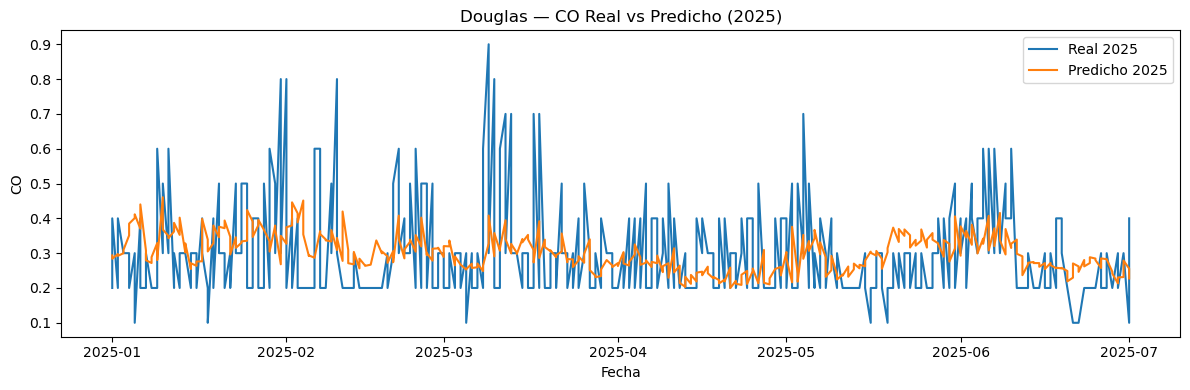

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt

model = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
pred_test = model.predict(X_test)

mae  = mean_absolute_error(y_test, pred_test)
rmse = root_mean_squared_error(y_test, pred_test)  # 👈 sin 'squared'
r2   = r2_score(y_test, pred_test)

print(f"[2025] MAE={mae:.4f} RMSE={rmse:.4f} R²={r2:.4f}")

plt.figure(figsize=(12,4))
plt.plot(test["date"], y_test, label="Real 2025")
plt.plot(test["date"], pred_test, label="Predicho 2025")
plt.title("Douglas — CO Real vs Predicho (2025)")
plt.xlabel("Fecha"); plt.ylabel("CO")
plt.legend(); plt.tight_layout(); plt.show()
